# 5.4. Wrapping a C library in Python with ctypes

In [1]:
%%writefile mandelbrot.c
#include "stdio.h"
#include "stdlib.h"

void mandelbrot(int size, int iterations, int *col)
{
    // Variable declarations.
    int i, j, n, index;
    double cx, cy;
    double z0, z1, z0_tmp, z0_2, z1_2;

    // Loop within the grid.
    for (i = 0; i < size; i++)
    {
        cy = -1.5 + (double)i / size * 3;
        for (j = 0; j < size; j++)
        {
            // We initialize the loop of the system.
            cx = -2.0 + (double)j / size * 3;
            index = i * size + j;
            // Let's run the system.
            z0 = 0.0;
            z1 = 0.0;
            for (n = 0; n < iterations; n++)
            {
                z0_2 = z0 * z0;
                z1_2 = z1 * z1;
                if (z0_2 + z1_2 <= 100)
                {
                    // Update the system.
                    z0_tmp = z0_2 - z1_2 + cx;
                    z1 = 2 * z0 * z1 + cy;
                    z0 = z0_tmp;
                    col[index] = n;
                }
                else
                {
                    break;
                }
            }
        }
    }
}

Overwriting mandelbrot.c


In [18]:
#!gcc -shared -Wall -O2 -Wall -pedantic -Wl,-soname,mandelbrot -fPIC -o mandelbrot.so  mandelbrot.c
!gcc -c -Wall -O2 -Wall -pedantic -fPIC -o mandelbrot.o mandelbrot.c
!gcc -shared -Wl,-soname,mandelbrot -o mandelbrot.so mandelbrot.o

In [19]:
import ctypes

In [25]:
lib = ctypes.CDLL('./mandelbrot.so')

In [26]:
mandelbrot = lib.mandelbrot

In [27]:
from numpy.ctypeslib import ndpointer

In [28]:
# Define the types of the output and arguments of
# this function.
mandelbrot.restype = None
mandelbrot.argtypes = [ctypes.c_int,
                       ctypes.c_int,
                       ndpointer(ctypes.c_int),
                       ]

In [29]:
import numpy as np
# We initialize an empty array.
size = 400
iterations = 100
col = np.empty((size, size), dtype=np.int32)
# We execute the C function, which will update
# the array.
mandelbrot(size, iterations, col)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

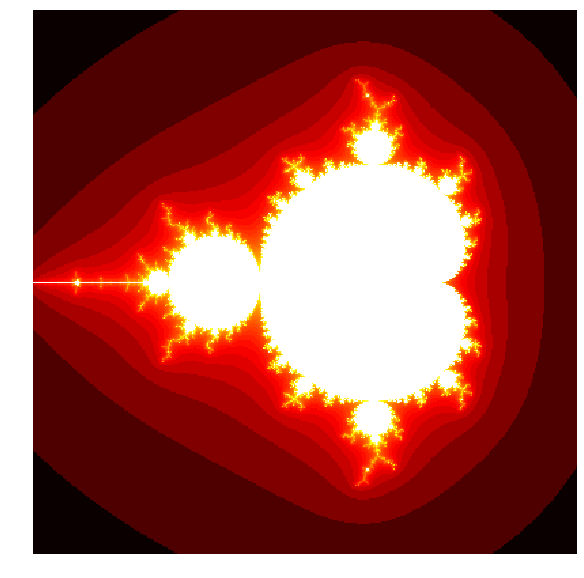

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(col), cmap=plt.cm.hot)
ax.set_axis_off()

In [32]:
%timeit mandelbrot(size, iterations, col)

14.7 ms ± 90 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cleanup

In [1]:
!rm -f mandelbrot.c
!rm -f mandelbrot.o